In [8]:
from dotenv import load_dotenv
from typing import Annotated
import os

load_dotenv()

AZURE_OPENAI_API_KEY = os.getenv("AZURE_OPENAI_API_KEY")
AZURE_OPENAI_ENDPOINT = os.getenv("AZURE_OPENAI_ENDPOINT")

from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition

In [10]:

class State(TypedDict):
    messages: Annotated[list, add_messages]

@tool
def get_stock_price(symbol: str) -> float:
    '''Return the current price of a stock given the stock symbol
    :param symbol: stock symbol
    :return: current price of the stock
    '''
    return {
        "MSFT": 200.3,
        "AAPL": 100.4,
        "AMZN": 150.0,
        "RIL": 87.6
    }.get(symbol, 0.0)

tools = [get_stock_price]


In [11]:
# from langchain.chat_models import init_chat_model
from langchain_openai import AzureChatOpenAI
# llm = init_chat_model("google_genai:gemini-2.0-flash")
# llm.invoke("who was the person to walk on the moon")

openai_llm = AzureChatOpenAI(
    azure_deployment="gpt-4o-mini",
    api_key=AZURE_OPENAI_API_KEY or "",
    azure_endpoint=AZURE_OPENAI_ENDPOINT or "",
    api_version="2024-12-01-preview",
    stream_usage=True,
)

llm_with_tools = openai_llm.bind_tools(tools)
# openai_llm.invoke("who was the person to walk on the moon")

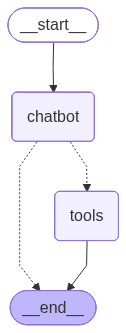

In [12]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


builder = StateGraph(State)

builder.add_node(chatbot)
builder.add_node("tools", ToolNode(tools))


builder.add_edge(START, "chatbot")
builder.add_conditional_edges("chatbot", tools_condition)

graph = builder.compile()

from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
state = graph.invoke({"messages": [{"role": "user", "content": "What is the price of AAPL stock right now?"}]})
print(state["messages"][-1].content)

100.4


In [14]:
state = graph.invoke({"messages": [{"role": "user", "content": "Who invented theory of relativity? print person name only"}]})
print(state["messages"][-1].content)

Albert Einstein


In [15]:
msg = "I want to buy 20 AMZN stocks using current price. Then 15 MSFT. What will be the total cost?"

state = graph.invoke({"messages": [{"role": "user", "content": msg}]})
print(state["messages"][-1].content)

200.3
